In [ ]:
import csv
import math
from collections import defaultdict, Counter

DATA_FILE = "2024_fb_ads_president_scored_anon.csv"

def mean(numbers):
    return sum(numbers) / len(numbers) if numbers else 0

def std_dev(numbers):
    avg = mean(numbers)
    variance = sum((x - avg) ** 2 for x in numbers) / len(numbers) if numbers else 0
    return math.sqrt(variance)

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def read_csv(file_path):
    with open(file_path, mode="r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        return list(reader)

def generate_stats(data):
    columns = data[0].keys()
    stats = {}

    for col in columns:
        values = [row[col].strip() for row in data if row[col].strip() != '']
        numeric_values = [float(v) for v in values if is_number(v)]

        if numeric_values:
            stats[col] = {
                "count": len(numeric_values),
                "mean": round(mean(numeric_values), 2),
                "min": min(numeric_values),
                "max": max(numeric_values),
                "std_dev": round(std_dev(numeric_values), 2)
            }
        else:
            counter = Counter(values)
            stats[col] = {
                "count": len(values),
                "unique_count": len(set(values)),
                "most_frequent": counter.most_common(1)[0] if counter else None
            }

    return stats

def group_by(data, group_cols):
    grouped = defaultdict(list)
    for row in data:
        key = tuple(row[col] for col in group_cols)
        grouped[key].append(row)
    return grouped

def write_stats_to_csv(stats_dict, output_file, group_label=None):
    with open(output_file, mode='a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for col, stats in stats_dict.items():
            for stat_key, value in stats.items():
                writer.writerow([group_label or "overall", col, stat_key, value])

if __name__ == "__main__":
    # Clear old files before writing
    open("summary_overall.csv", 'w').close()
    open("summary_grouped_page_id.csv", 'w').close()
    open("summary_grouped_page_id_ad_id.csv", 'w').close()

    data = read_csv(DATA_FILE)

    # Overall stats
    overall_stats = generate_stats(data)
    write_stats_to_csv(overall_stats, "summary_overall.csv")

    # Grouped by page_id
    page_groups = group_by(data, ["page_id"])
    for group_key, group_data in page_groups.items():
        stats = generate_stats(group_data)
        group_label = f"page_id={group_key[0]}"
        write_stats_to_csv(stats, "summary_grouped_page_id.csv", group_label)

    # Grouped by page_id and ad_id — only process top 10 groups
page_ad_groups = group_by(data, ["page_id", "ad_id"])
top_10_keys = list(page_ad_groups.keys())[:10]

for group_key in top_10_keys:
    group_data = page_ad_groups[group_key]
    stats = generate_stats(group_data)
    group_label = f"page_id={group_key[0]} | ad_id={group_key[1]}"
    write_stats_to_csv(stats, "summary_grouped_page_id_ad_id.csv", group_label)


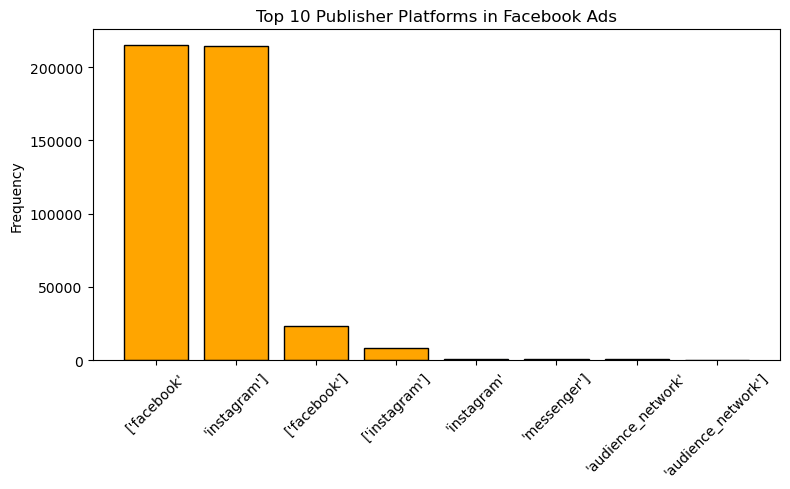

In [1]:
import csv
import matplotlib.pyplot as plt
from collections import Counter

# Load data
file_path = "2024_fb_ads_president_scored_anon.csv"
with open(file_path, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    platforms = []

    for row in reader:
        raw = row.get("publisher_platforms", "")
        platforms.extend([p.strip() for p in raw.split(",") if p.strip()])

# Count platform frequency
platform_counts = Counter(platforms)
top_platforms = platform_counts.most_common(10)
labels, values = zip(*top_platforms)

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color="orange", edgecolor="black")
plt.title("Top 10 Publisher Platforms in Facebook Ads")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("fb_ads_bar_platforms.png")
plt.show()
